In [1]:
import glob
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import pickle
SEED = 42
%matplotlib inline

## READ DATASET IMAGES

In [2]:
images = glob.glob('all/*.jpeg')
cars = []
notcars = []
for image in glob.glob('all/*.jpeg'):
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

#for image in glob.glob('all/non-vehicles/*.jpeg'):
#    notcars.append(image)
        

print('Dataset size: Cars {} | NotCars {}'.format(len(cars), len(notcars)))
print('Dataset is balanced')

Dataset size: Cars 1196 | NotCars 1125
Dataset is balanced


## EXAMPLES

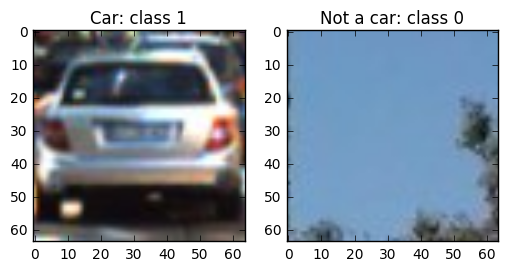

In [3]:
rand_car = np.random.choice(len(cars))
rand_notcar = np.random.choice(len(notcars))
this_car = mpimg.imread(cars[rand_car])
this_notcar = mpimg.imread(notcars[rand_notcar])

plt.figure(1)
plt.axis('off')
plt.subplot(121)
plt.title('Car: class 1')
plt.imshow(this_car)
plt.subplot(122)
plt.title('Not a car: class 0')
plt.imshow(this_notcar)
plt.show()

## FUNCTIONS FOR FEATURE EXTRACTION

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Extract HOG image and HOG features of a given image
    orient: number of bins for the orientation
    pix_per_cell: size of a cell
    cell_per_block: nber of cells per block
    vis (Boolean) visualize the HOG image
    feature_vec (Boolean): return the features as a feature vector
    By default, the function uses transform_sqrt (apply power law compression to normalize the image before processing)
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



def bin_spatial(img, size=(32, 32)):
    '''
    Binned Color Feature
    img: original image
    size: target size of the image
    output: feature vector
    '''
    features = cv2.resize(img, size).ravel() 
    return features



def color_hist(img, nbins=32, bins_range=(0, 256)):
    '''
    Color histogram features for each channel of the original image
    img: original image
    nbins: number of bins of the histogram
    output: concatenate feature vector
    '''
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_vis=False):
    '''
    Feature extractor: extract features from a list of images
    The function calls bin_spatial(), color_hist() and get_hog_features
    ''' 
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if hog_vis == False:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        #color conversion
        if color_space in ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+color_space) )
        else: feature_image = np.copy(image)      
        #Image size: add all pixels of reduced image as vector
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        #Histogram of reduced image: add histogram as a vector
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        #HOG of reduced image: add HOG as feature vector
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    if hog_vis:
                        hog_feature, hog_image = get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
                        res = cv2.addWeighted( cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 0.1, (hog_image/np.max(hog_image)*255).astype('uint8'), 0.1, 0.0)
                        # Plot the examples
                        fig = plt.figure()
                        plt.title(channel)
                        plt.subplot(131)
                        plt.imshow(image, cmap='gray')
                        plt.title('Original Image')
                        plt.subplot(132)
                        plt.imshow(hog_image, cmap='gray')
                        plt.title('HOG')
                        plt.subplot(133)
                        plt.imshow(res, cmap='gray')
                        plt.title('overlapped')
                        plt.show()
                    
                    else:
                        hog_feature = get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)
                        
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


## SETTINGS FOR FEATURE EXTRACTION

In [5]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
hist_range = bins_range = (0,256)
spatial_feat = True  # Spatial features on or off
hist_feat = False  # Histogram features on or off
hog_feat = True  # HOG features on or off

## VISUALIZATION OF HOG IMAGES

Image adress:  all/extra07_152.jpeg


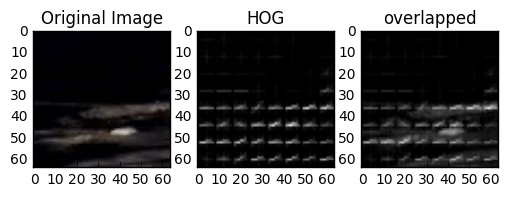

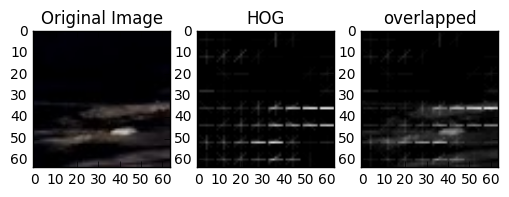

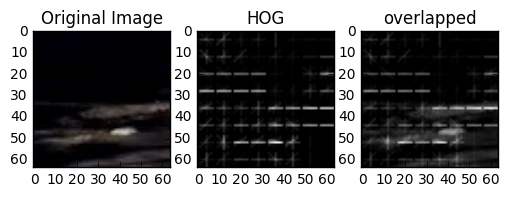

In [6]:
#randomly select example
rand_img = np.random.choice(np.arange(0, len(notcars), 1))

print('Image adress: ', notcars[rand_img])
feat = extract_features([notcars[rand_img]], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, hog_vis=True)

## BUILD DATASET WITH FEATURE EXTRACTION

In [7]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

#Group cars and notcars images in a single array
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Normalize Data: fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets (shuffle included)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=SEED)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Mean of example 0 {} | std {}'.format(np.mean(X_train[10]), np.std(X_train[0])))

Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7248
Mean of example 0 -0.049276092933114364 | std 1.538302407385906


## RUN CLASSIFIER
Linear Suppor Vector machine Classifier

In [8]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.35 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9892
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  1.  1.  0.]
0.00472 Seconds to predict 10 labels with SVC


## SAVE THE MODEL

In [9]:
model_svc = 'model_svc.p'
try:
    with open(model_svc, 'wb') as pfile:
        pickle.dump(
            {   'X_dataset': X,
                'y_dataset': y,
                'svc':svc, 
                'X_scaler': X_scaler,
                'color_space': color_space,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': spatial_feat,
                'hist_feat': hist_feat,
                'hog_feat':hog_feat
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', model, ':', e)
    raise
